In [1]:
import numpy
import matplotlib.pyplot as plt
import pandas as pd 
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

/Users/dosya/Projects/lab_iis/jupyter/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# convert an array of values into a dataset matrix
def create_dataset(d, look_back=1):
    df = pd.DataFrame()
    for i, col in enumerate(dataframe.columns):
        df[col] = d.T[i]
    d = df
    # normalize the dataset
    x_train, y_train = d.drop(["load", "amount"],axis=1).as_matrix(), d[["load", "amount"]].as_matrix()
    scaler_x = MinMaxScaler(feature_range=(0, 1)).fit(x_train)
    scaler_y = MinMaxScaler(feature_range=(0, 1)).fit(y_train)
    x_train = scaler_x.transform(x_train)
    y_train = scaler_y.transform(y_train)
    return numpy.array(x_train), numpy.array(y_train), scaler_x, scaler_y

In [3]:
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = pd.read_csv("preprocessed.csv").drop("Unnamed: 0", axis=1)

In [4]:
from keras_tqdm import TQDMNotebookCallback
dataset = dataframe
dataset = dataset.astype('float32').as_matrix()

In [5]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY, scaler_trainX, scaler_trainY = create_dataset(train, look_back)
testX, testY, scaler_testX, scaler_testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(2, input_shape=(look_back, 16)))
model.add(Dense(2))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=32, verbose=2, validation_split=0.2)

Train on 4739290 samples, validate on 1184823 samples
Epoch 1/100
 - 399s - loss: 6.4766e-04 - val_loss: 5.6461e-06
Epoch 2/100
 - 382s - loss: 1.0085e-04 - val_loss: 1.0332e-05
Epoch 3/100
 - 377s - loss: 9.8775e-05 - val_loss: 1.0544e-05
Epoch 4/100
 - 381s - loss: 9.7825e-05 - val_loss: 1.7886e-05
Epoch 5/100
 - 377s - loss: 9.7253e-05 - val_loss: 1.4393e-05
Epoch 6/100
 - 422s - loss: 9.6832e-05 - val_loss: 1.4091e-05
Epoch 7/100


KeyboardInterrupt: 

In [6]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
print(scaler_trainX.transform(create_dataset(train, look_back)[0]).shape)
print(trainX.shape)
print(trainPredict.shape)
print()
print(scaler_trainY.transform(create_dataset(train, look_back)[1]).shape)
print(trainY.shape)
print(trainPredict.shape)

(5924113, 16)
(5924113, 1, 16)
(5924113, 2)

(5924113, 2)
(5924113, 2)
(5924113, 2)


In [7]:
# invert predictions
trainPredict = scaler_trainY.inverse_transform(trainPredict)
trainY = scaler_trainY.inverse_transform(trainY)
testPredict = scaler_testY.inverse_transform(testPredict)
testY = scaler_trainY.inverse_transform(testY)

Train Score: 145.52 RMSE
Test Score: 345.88 RMSE


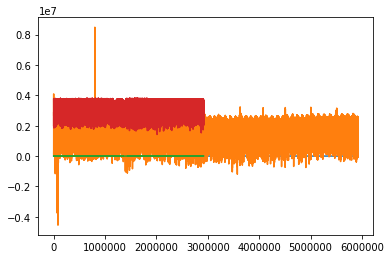

In [9]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(trainPredict)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot = testPredict
# plot baseline and predictions
plt.plot(scaler_trainY.inverse_transform(trainPredict))
plt.plot(scaler_trainY.inverse_transform(testPredict))
plt.show()

In [ ]:
numpy.concatenate((trainPredictPlot, np.full((len(trainPredictPlot), 16), np.nan)), axis=1)